### <center>Курс: "Введение в анализ данных (1 семестр)"</center>

# <center>Группа 8</center>

<center><b>Состав группы:</b> Белялова Мария, Лопаткин Владимир, Постников Михаил</center>

## <center>Задание:</center>

Цель работы определить о чем датасет + найти в нем что-то интересное.

Исследование должно быть выполнено по методологии cхожей с CRISP-DM. А именно, обязательно должны быть фазы:
- 1) Определение задач и целей исследования
- 2) Понимание данных (аналогично CRISP-DM) (в том числе визуализация данных)
- 3) Подготовка данных (аналогично CRISP-DM)
- 4) Непосредственно исследование. А именно, проверка гепотез, визуализация результатов и т.д.
- 5) Подведение итогов исследования.

Фаза "Понимание данных" должна быть выполнена в соответствии с протоколом разведочного анализа данных http://iis4.nateko.lu.se/courses/ngem01/ZuurEtAl_2010_Stistics.pdf (но, без фанатизма, с учетом имеющихся датасетов).

Работа должна разделяться на разделы в соответствии с методологией.

- За часть связанной с <b>обработкой и разведочным анализом данных (а именно с построением графиков, показывающих структуру, раскрывающих ключивые моменты и ставящих задачи для дальнейшего анализа)</b> можно заработать 20 баллов, при условии, что <b>будут использоваться не менее 5 типов графиков (в том числе один связанный с нанесением данных на карту)</b>. Общего кол-ва графиков должно быть достаточно для того, чтобы понять структуру данных (но не меньше, чем по 4-5 графика на человека в группе).


- За <b>выдвижение и проверку различных статистических гипотез</b> на основе данных можно заработать еще 10 баллов. Гипотезы должны быть разных типов (простая VS простая, простая VS сложная, сложная VS сложная). Кроме того, нужно будет <b>использовать как минимум 1-2 статистических критерия</b>.

 <b>Достаточно будет сделать проверку 2-х гипотез (на группу)</b>:
  - в качестве простой - тест на проверку значения какой-либо оценки
  - в качестве сложной (критерий согласия/тест на равенство параметров в выборочных совокупностях):
   - использован критерий согласия для проверки гипотезы о виде распределения;
   - проверена гипотеза о равенстве параметров в различных совокупностях.
  

- За <b>анализ временного ряда</b> (1-3 на группу) можно будет получить еще 10 баллов. Под анализом понимается: <b>обнаружения тренда, сезонности в данных. Формирования прогноза и построение доверительных интерваллов для него</b>.

$$[---------------------------------------------]$$

Для дополнительного изучения анализа временных рядов рекомендуется курс лекций "Анализ временных рядов" Канторовича Г.Г.

## <center>Вариант задания - 4</center>

4. Агрегированная информация по сделкам с недвижимостью в городе New York https://nycopendata.socrata.com/data?agency=Department+of+Finance+%28DOF%29&cat=housing%20%26%20development&type=datasets&browseSearch=&scope=

Данные:
- Cooperative comparable rental inclome.
- Queens, Manhattan, Bronx, Brooklyn, Staten Island
- 2008-2012 years

Информация о датасетах:

- Condominiums and cooperatives are valued as if they were residential rental apartments. Income information from similar rental properties is applied to determine value. 
The Department of Finance (DOF) chooses similar properties to value condos and coops. Properties are selected based on a combination of factors such as: <b>land location, income levels, building age and construction and exemptions and subsidies</b>.

# <center>Решение</center>

## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import requests
import json
import mpl_toolkits.basemap as bm

In [3]:
%matplotlib inline

In [4]:
plt.style.use('ggplot')

## Реализация функций

#### Dataframe

In [5]:
def joinAndRemoveColumn(df, column_1, column_2):
    _slice = pd.isnull(df[column_1])
    df[column_1][_slice] = df[column_2][_slice]
    df.drop(column_2, axis=1, inplace=True)
    print "Removed column: " + column_2

In [6]:
def renameColumns(df):
    columns = df.columns
    newnames = {}
    for name in columns:
        newname = name.replace("–", "--")
        startPos = newname.find('COOPERATIVES COMPARABLE PROPERTIES')
        if startPos != -1: newname = newname[startPos:]
        newnames[name] = newname
    return df.rename(columns=newnames)

In [7]:
def getPropeties(df):
    properties = []
    for name in df.columns:
        if name.find('COOPERATIVES COMPARABLE PROPERTIES') != -1:
            prop = name[name.rfind("--") + 3:]
            properties.append(prop)
    return properties

In [8]:
def getLatLong(string):
    br1 = string.rfind("(")
    comma = string.rfind(",")
    br2 = string.rfind(")")
    
    lat0, lon0 = 40.7058316, -74.2581872
    
    if (br1 == -1 or br2 == -1 or comma == -1):
        return lat0, lon0
    
    lat, lon = float(string[br1+1:comma]), float(string[comma+1: br2])
    if (lat > 42 or lat < 38 or lon < -76 or lon > -72 ): return lat0, lon0
    return lat, lon

In [64]:
def drawOnNYMap(x, y, colors = None, size = 10, s=40):
    img = plt.imread("new_york.png")
    corners = [[-74.272950, 40.489464], [-73.694915, 40.938429]]
    
    plt.figure(figsize=(size, size))
    
    plt.xlim((corners[0][0], corners[1][0]))
    plt.ylim((corners[0][1], corners[1][1]))
    plt.imshow(img, extent=[corners[0][0], corners[1][0], corners[0][1], corners[1][1]], aspect=1.2)
     
    plt.scatter(x, y, marker='o', s=s, c = None if colors is None else colors)

In [67]:
def getColors(vals, colormap = 'coolwarm'):
    cm = plt.get_cmap(colormap)
    maxe = mainDF.Market_Value_per_SqFt.max()
    return map(lambda val: cm(val / maxe), vals)

## Основной блок

#### Глобальные переменные

In [10]:
datasetsPath = "./Datasets"
years = range(2008, 2013)
cooperativePath = "/".join([datasetsPath,"Cooperative"])
#condiminiumPath = "/".join([datasetsPath, "Condominium"])

In [11]:
colors = {"Staten_Island": 'b',
             "Bronx": 'r',
             "Brooklyn": 'g',
             "Queens": 'y',
             "Manhattan": 'm'}

#### http://www.machinelearning.ru/wiki/index.php?title=CRISP-DM

### 1) Определение задач и целей исследования

Первая фаза процесса направлена на определение целей проекта. Затем эти знания конвертируются в постановку задачи интеллектуального анализа данных и предварительный план достижения целей проекта.

- Определить цели
- Оценить ситуацию
- Определить цели анализа данных
- Составить план проекта

Перед нами стоит задача изучить набор данных, понять - какую полезную информацию из них можно извлечь.
Для этого:
- Сначала объединим собранные данные, очистим их от плохих значений, посмотрим на полученные данные.
- Визуализируем переменные, посмотрим зависимости, сделаем некоторые предположения и проверим их.
- Затем подведем итоги проделанной работы.

### 2) Понимание данных (в том числе визуализация данных)

Вторая фаза начинается со сбора данных и ставит целью познакомиться с данными как можно ближе. Для этого необходимо выявить проблемы с качеством данных такие как ошибки или пропуски, понять что за данные имеются в наличии, попробовать отыскать интересные наборы данных или сформировать гипотезы о наличии скрытых закономерностей в данных.
- Собрать исходные данные (загрузить в датафреймы)
- Описать данные (что значат переменные)
- Исследовать данные
- Проверить качество данных (значения NULL, все ли правильно внесены, нет ли некорректных данных, столбцы объединить)

#### http://iis4.nateko.lu.se/courses/ngem01/ZuurEtAl_2010_Stistics.pdf

$$[---------------------------------------------]$$

Загрузим <b>Cooperative</b> датасеты, добавим в каждый датафрейм столбец с годом и названием района

In [12]:
cooperativeDF = {}
for year in years[:-1]:
    folderName = "%d_%d" % (year, year+1)
    cooperativePathByYears = '/'.join([cooperativePath, folderName])
    for filename in os.listdir(cooperativePathByYears):
        district = filename[filename.find("___")+3:]
        district = district[:district.find("__")]
        df = pd.read_csv('/'.join([cooperativePathByYears, filename]))
        df['Year'] = year
        df['District'] = district
        if cooperativeDF.has_key(district):
            cooperativeDF[district] = pd.concat([cooperativeDF[district], df])
            cooperativeDF[district].index = range(len(cooperativeDF[district]))
        else:
            cooperativeDF[district] = df

In [13]:
for i, col in enumerate(cooperativeDF['Staten_Island'].columns):
    print "%2d: %s" % (i, col)

 0: COMPARABLE RENTAL – 1 – Address
 1: COMPARABLE RENTAL – 1 – Boro-Block-Lot
 2: COMPARABLE RENTAL – 1 – Building Classification
 3: COMPARABLE RENTAL – 1 – Distance from Coop in miles
 4: COMPARABLE RENTAL – 1 – Estimated Expense
 5: COMPARABLE RENTAL – 1 – Estimated Gross Income
 6: COMPARABLE RENTAL – 1 – Expense per SqFt
 7: COMPARABLE RENTAL – 1 – Full Market Value
 8: COMPARABLE RENTAL – 1 – Gross Income per SqFt
 9: COMPARABLE RENTAL – 1 – Gross SqFt
10: COMPARABLE RENTAL – 1 – Market Value per SqFt
11: COMPARABLE RENTAL – 1 – Neighborhood
12: COMPARABLE RENTAL – 1 – Net Operating Income
13: COMPARABLE RENTAL – 1 – Total Units
14: COMPARABLE RENTAL – 1 – Year Built
15: COMPARABLE RENTAL – 1 –Address
16: COMPARABLE RENTAL – 1 –Boro-Block-Lot
17: COMPARABLE RENTAL – 1 –Building Classification
18: COMPARABLE RENTAL – 1 –Dist. from Coop in miles
19: COMPARABLE RENTAL – 1 –Est. Gross Income
20: COMPARABLE RENTAL – 1 –Full Market Value
21: COMPARABLE RENTAL – 1 –Gross Income per SqF

In [14]:
cooperativeDF['Staten_Island'][cooperativeDF['Staten_Island']['Year'] == 2008][cooperativeDF['Staten_Island'].columns[[0, 15, 5, 19, 54, 73, 75]]].head(1)

,COMPARABLE RENTAL – 1 – Address,COMPARABLE RENTAL – 1 –Address,COMPARABLE RENTAL – 1 – Estimated Gross Income,COMPARABLE RENTAL – 1 –Est. Gross Income,COMPARABLE RENTAL – 3 – Address,STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES – Est. Gross Income,STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES – Estimated Gross Income
0,NaN,"163 JERSEY STREET\nStaten Island, NY\n(40.6437...",NaN,2677642,NaN,1839705,NaN


In [15]:
cooperativeDF['Staten_Island'][cooperativeDF['Staten_Island']['Year'] == 2010][cooperativeDF['Staten_Island'].columns[[0, 15, 5, 19, 54, 73, 75]]].head(1)

,COMPARABLE RENTAL – 1 – Address,COMPARABLE RENTAL – 1 –Address,COMPARABLE RENTAL – 1 – Estimated Gross Income,COMPARABLE RENTAL – 1 –Est. Gross Income,COMPARABLE RENTAL – 3 – Address,STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES – Est. Gross Income,STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES – Estimated Gross Income
46,NaN,"163 JERSEY STREET\nStaten Island, NY\n(40.6437...",NaN,2840710,NaN,1951743,NaN


In [16]:
cooperativeDF['Staten_Island'][cooperativeDF['Staten_Island']['Year'] == 2011][cooperativeDF['Staten_Island'].columns[[0, 15, 5, 19, 54, 73, 75]]].head(1)

,COMPARABLE RENTAL – 1 – Address,COMPARABLE RENTAL – 1 –Address,COMPARABLE RENTAL – 1 – Estimated Gross Income,COMPARABLE RENTAL – 1 –Est. Gross Income,COMPARABLE RENTAL – 3 – Address,STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES – Est. Gross Income,STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES – Estimated Gross Income
70,"285 ST MARK'S PLACE\nStaten Island, NY\n(40.64...",NaN,1012863,NaN,NaN,NaN,1719172


 Полученные датафреймы необходимо будет объединить. Но перед этим - произвести переименование столбцов, имеющих общие характеристики

$$[---------------------------------------------]$$

Опишем значения столбцов

In [17]:
cooperativeDF['Staten_Island'].columns

Index([u'COMPARABLE RENTAL – 1 – Address',
       u'COMPARABLE RENTAL – 1 – Boro-Block-Lot',
       u'COMPARABLE RENTAL – 1 – Building Classification',
       u'COMPARABLE RENTAL – 1 – Distance from Coop in miles',
       u'COMPARABLE RENTAL – 1 – Estimated Expense',
       u'COMPARABLE RENTAL – 1 – Estimated Gross Income',
       u'COMPARABLE RENTAL – 1 – Expense per SqFt',
       u'COMPARABLE RENTAL – 1 – Full Market Value',
       u'COMPARABLE RENTAL – 1 – Gross Income per SqFt',
       u'COMPARABLE RENTAL – 1 – Gross SqFt',
       u'COMPARABLE RENTAL – 1 – Market Value per SqFt',
       u'COMPARABLE RENTAL – 1 – Neighborhood',
       u'COMPARABLE RENTAL – 1 – Net Operating Income',
       u'COMPARABLE RENTAL – 1 – Total Units',
       u'COMPARABLE RENTAL – 1 – Year Built',
       u'COMPARABLE RENTAL – 1 –Address',
       u'COMPARABLE RENTAL – 1 –Boro-Block-Lot',
       u'COMPARABLE RENTAL – 1 –Building Classification',
       u'COMPARABLE RENTAL – 1 –Dist. from Coop in miles',
    

- <b>'Address'</b> - адрес здания
- <b>'Boro-Block-Lot'</b> - идентификатор здания/индекс
- <b>'Building Classification'</b> - тип строения
- <b>'Estimated Expense'</b> - предполагаемые издержки
- <b>'Estimated Gross Income'</b> - предполагаемый валовый доход
- <b>'Expense per SqFt'</b> - стоимость квадратного фута
- <b>'Full Market Value'</b> - полная цена на рынке
- <b>'Gross Income per SqFt'</b> - валовый доход за квадратный фут
- <b>'Gross SqFt'</b> - общая жилая площадь
- <b>'Market Value per SqFt'</b> - рыночная цена за квадратный фут
- <b>'Neighborhood'</b> - район
- <b>'Net Operating Income'</b> - операционная прибыль
- <b>'Total Units'</b> - сдаваемая площадь
- <b>'Year Built'</b> - год постройки
- <b>'Distance from Coop in miles'</b> - расстояние от текущего адреса до сравниваемого места в милях
- <b>'COMPARABLE RENTAL...'</b> - жилье, находящееся неподалеку от текущего, используемое для оценки доходов

$$[---------------------------------------------]$$

Немного графиков, чтобы оценить значения этих свойст

### 3) Подготовка данных

Фаза подготовки данных ставит целью получить итоговый набор данных, которые будут использоваться при моделировании, из исходных разнородных и разноформатных данных. Задачи подготовки данных могут выполняться много раз без какого-либо наперед заданного порядка. Они включают в себя отбор таблиц, записей и атрибутов, а также конвертацию и очистку данных для моделирования.
- Отобрать данные (удалить ненужные столбцы)
- Очистить данные (избавиться от неопределенных значений)
- Сделать производные данные (дополнительные столбцы, вычисления)
- Объединить данные (если необходимо)
- Привести данные в нужный формат (числа в числа, строки в строки, получить хороший датафрейм)

<b>Переименуем столбцы с названиями районов</b>
- STATEN ISLAND – COOPERATIVES COMPARABLE PROPERTIES

в
- COOPERATIVES COMPARABLE PROPERTIES

для общности

In [18]:
for key in cooperativeDF.keys():
    cooperativeDF[key] = renameColumns(cooperativeDF[key])

#### Как мы заметили, многие столбцы имеют схожие названия (видимо, в 2011 году переименовали столбцы с сокращениями) - объединим их и удалим повторяющиеся

- 'BRONX – COOPERATIVES COMPARABLE PROPERTIES – Est. Gross Income'
- 'BRONX – COOPERATIVES COMPARABLE PROPERTIES – Estimated Gross Income'


- 'COMPARABLE RENTAL – 1 – Address'
- 'COMPARABLE RENTAL – 1 –Address'

и другие

#### Соберем список свойств, по которым сравниваются данные

In [19]:
properties = {}
for key in cooperativeDF.keys():
    properties[key] = getPropeties(cooperativeDF[key])

In [20]:
properties['Bronx'] == properties['Brooklyn'] == properties['Staten_Island'] == properties['Manhattan'] == properties['Queens']

True

#### Избавляемся от словаря и оставляем один список свойств, так как они вышли одинаковые

In [21]:
properties = getPropeties(cooperativeDF['Bronx'])
properties

['Address',
 'Boro-Block-Lot',
 'Building Classification',
 'Est. Gross Income',
 'Estimated Expense',
 'Estimated Gross Income',
 'Expense per SqFt',
 'Full Market Value',
 'Gross Income per SqFt',
 'Gross SqFt',
 'Market Value per SqFt',
 'Neighborhood',
 'Net Operating Income',
 'Total Units',
 'Year Built']

####  Собственно производим объединение и удаление

In [22]:
beginnings = ['COMPARABLE RENTAL -- 1 --',
              'COMPARABLE RENTAL -- 2 --',
              'COMPARABLE RENTAL -- 3 --']

for key in cooperativeDF.keys():
    columns = cooperativeDF[key].columns
    
    #PROPERTIES COLUMNS
    beg = 'COOPERATIVES COMPARABLE PROPERTIES -- '
    column = (beg + 'Distance from Coop in miles')
    if ((beg + 'Dist. from Coop in miles') in columns) & (column in columns):
        joinAndRemoveColumn(cooperativeDF[key], column, beg + 'Dist. from Coop in miles')
    column = (beg + 'Estimated Gross Income')
    if ((beg + 'Est. Gross Income') in columns) & (column in columns):
        joinAndRemoveColumn(cooperativeDF[key], column, beg + 'Est. Gross Income')

    #OTHER COLUMNS
    for beg in beginnings:
        column = (beg + ' ' + 'Distance from Coop in miles')
        if ((beg + 'Dist. from Coop in miles') in columns) & (column in columns):
            joinAndRemoveColumn(cooperativeDF[key], column, beg + 'Dist. from Coop in miles')
        column = (beg + ' ' + 'Estimated Gross Income')
        if ((beg + 'Est. Gross Income') in columns) & (column in columns):
            joinAndRemoveColumn(cooperativeDF[key], column, beg + 'Est. Gross Income')
        for prop in properties:
            column = (beg + ' ' + prop)
            if ((beg + prop) in columns) & (column in columns):
                joinAndRemoveColumn(cooperativeDF[key], column, beg+prop)

Removed column: COOPERATIVES COMPARABLE PROPERTIES -- Est. Gross Income
Removed column: COMPARABLE RENTAL -- 1 --Dist. from Coop in miles
Removed column: COMPARABLE RENTAL -- 1 --Est. Gross Income
Removed column: COMPARABLE RENTAL -- 1 --Address
Removed column: COMPARABLE RENTAL -- 1 --Boro-Block-Lot
Removed column: COMPARABLE RENTAL -- 1 --Building Classification
Removed column: COMPARABLE RENTAL -- 1 --Full Market Value
Removed column: COMPARABLE RENTAL -- 1 --Gross Income per SqFt
Removed column: COMPARABLE RENTAL -- 1 --Gross SqFt
Removed column: COMPARABLE RENTAL -- 1 --Market Value per SqFt
Removed column: COMPARABLE RENTAL -- 1 --Neighborhood
Removed column: COMPARABLE RENTAL -- 1 --Total Units
Removed column: COMPARABLE RENTAL -- 1 --Year Built
Removed column: COMPARABLE RENTAL -- 2 --Dist. from Coop in miles
Removed column: COMPARABLE RENTAL -- 2 --Est. Gross Income
Removed column: COMPARABLE RENTAL -- 2 --Address
Removed column: COMPARABLE RENTAL -- 2 --Boro-Block-Lot
Removed

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#### Теперь объединим датафреймы, удалим из датафрейма столбцы, количество NULL в которых превышает 25%

In [23]:
mainDF = pd.concat(cooperativeDF.values(), ignore_index=True)

In [24]:
nulls = pd.isnull(mainDF)
for column in mainDF.columns:
    if float(nulls[column].sum())/len(nulls) > 0.25:
        mainDF.drop(column, axis = 1, inplace = True)

In [25]:
mainDF.columns

Index([u'COMPARABLE RENTAL -- 1 -- Address',
       u'COMPARABLE RENTAL -- 1 -- Boro-Block-Lot',
       u'COMPARABLE RENTAL -- 1 -- Building Classification',
       u'COMPARABLE RENTAL -- 1 -- Distance from Coop in miles',
       u'COMPARABLE RENTAL -- 1 -- Estimated Gross Income',
       u'COMPARABLE RENTAL -- 1 -- Full Market Value',
       u'COMPARABLE RENTAL -- 1 -- Gross Income per SqFt',
       u'COMPARABLE RENTAL -- 1 -- Gross SqFt',
       u'COMPARABLE RENTAL -- 1 -- Market Value per SqFt',
       u'COMPARABLE RENTAL -- 1 -- Neighborhood',
       u'COMPARABLE RENTAL -- 1 -- Total Units',
       u'COMPARABLE RENTAL -- 1 -- Year Built',
       u'COMPARABLE RENTAL -- 2 -- Address',
       u'COMPARABLE RENTAL -- 2 -- Boro-Block-Lot',
       u'COMPARABLE RENTAL -- 2 -- Building Classification',
       u'COMPARABLE RENTAL -- 2 -- Distance from Coop in miles',
       u'COMPARABLE RENTAL -- 2 -- Estimated Gross Income',
       u'COMPARABLE RENTAL -- 2 -- Full Market Value',
       u'CO

#### Исходные данные объединены, можно приступить к описанию данных, визуализации, проверке качества данных

Далее работаем с датафреймом <b>mainDF</b>

Проверим на оставшиеся Null

In [26]:
pd.isnull(mainDF).any()

COMPARABLE RENTAL -- 1 -- Address                                 True
COMPARABLE RENTAL -- 1 -- Boro-Block-Lot                         False
COMPARABLE RENTAL -- 1 -- Building Classification                False
COMPARABLE RENTAL -- 1 -- Distance from Coop in miles            False
COMPARABLE RENTAL -- 1 -- Estimated Gross Income                 False
COMPARABLE RENTAL -- 1 -- Full Market Value                      False
COMPARABLE RENTAL -- 1 -- Gross Income per SqFt                  False
COMPARABLE RENTAL -- 1 -- Gross SqFt                             False
COMPARABLE RENTAL -- 1 -- Market Value per SqFt                  False
COMPARABLE RENTAL -- 1 -- Neighborhood                           False
COMPARABLE RENTAL -- 1 -- Total Units                            False
COMPARABLE RENTAL -- 1 -- Year Built                             False
COMPARABLE RENTAL -- 2 -- Address                                 True
COMPARABLE RENTAL -- 2 -- Boro-Block-Lot                          True
COMPAR

Что, если удалить все строки, содержащие хотя бы 1 NULL?

In [27]:
len(mainDF)

19079

In [28]:
len(mainDF.dropna())

18503

Отлично, потеряли всего 576 значений, оставим так

In [29]:
mainDF = mainDF.dropna()

$$[---------------------------------------------]$$

Некоторые переименования

In [30]:
columns = mainDF.columns

In [31]:
newcolumns = {}
for column in columns:
    newcolumn = column.replace("COMPARABLE RENTAL -- 1 -- ", "CR1_").replace("COMPARABLE RENTAL -- 2 -- ","CR2_")
    newcolumn = newcolumn.replace("COOPERATIVES COMPARABLE PROPERTIES -- ","").replace("-","_").replace(" ","_")
    newcolumns[column] = newcolumn
    

In [32]:
mainDF = mainDF.rename(columns=newcolumns)

In [33]:
mainDF.head(1)

,CR1_Address,CR1_Boro_Block_Lot,CR1_Building_Classification,CR1_Distance_from_Coop_in_miles,CR1_Estimated_Gross_Income,CR1_Full_Market_Value,CR1_Gross_Income_per_SqFt,CR1_Gross_SqFt,CR1_Market_Value_per_SqFt,CR1_Neighborhood,...,Estimated_Gross_Income,Full_Market_Value,Gross_Income_per_SqFt,Gross_SqFt,Market_Value_per_SqFt,Neighborhood,Total_Units,Year_Built,District,Year
0,"3900 GREYSTONE AVENUE\nBronx, NY\n(40.88950389...",2-05780-0940,D1-ELEVATOR,0.85,1397249,4720000,10.37,134703,35,RIVERDALE,...,1436270,5060000,11,130570,38.8,RIVERDALE,100,1961,Bronx,2008


$$[---------------------------------------------]$$

In [34]:
for i, column in enumerate(mainDF.columns):
    print "%2d: %s" % (i, column)

 0: CR1_Address
 1: CR1_Boro_Block_Lot
 2: CR1_Building_Classification
 3: CR1_Distance_from_Coop_in_miles
 4: CR1_Estimated_Gross_Income
 5: CR1_Full_Market_Value
 6: CR1_Gross_Income_per_SqFt
 7: CR1_Gross_SqFt
 8: CR1_Market_Value_per_SqFt
 9: CR1_Neighborhood
10: CR1_Total_Units
11: CR1_Year_Built
12: CR2_Address
13: CR2_Boro_Block_Lot
14: CR2_Building_Classification
15: CR2_Distance_from_Coop_in_miles
16: CR2_Estimated_Gross_Income
17: CR2_Full_Market_Value
18: CR2_Gross_Income_per_SqFt
19: CR2_Gross_SqFt
20: CR2_Market_Value_per_SqFt
21: CR2_Neighborhood
22: CR2_Total_Units
23: CR2_Year_Built
24: Address
25: Boro_Block_Lot
26: Building_Classification
27: Estimated_Gross_Income
28: Full_Market_Value
29: Gross_Income_per_SqFt
30: Gross_SqFt
31: Market_Value_per_SqFt
32: Neighborhood
33: Total_Units
34: Year_Built
35: District
36: Year


In [35]:
cols = mainDF.columns.tolist()

In [36]:
mainDF = mainDF[cols[24:]+cols[:24]]

In [37]:
for i, column in enumerate(mainDF.columns):
    print "%2d: %s" % (i, column)

 0: Address
 1: Boro_Block_Lot
 2: Building_Classification
 3: Estimated_Gross_Income
 4: Full_Market_Value
 5: Gross_Income_per_SqFt
 6: Gross_SqFt
 7: Market_Value_per_SqFt
 8: Neighborhood
 9: Total_Units
10: Year_Built
11: District
12: Year
13: CR1_Address
14: CR1_Boro_Block_Lot
15: CR1_Building_Classification
16: CR1_Distance_from_Coop_in_miles
17: CR1_Estimated_Gross_Income
18: CR1_Full_Market_Value
19: CR1_Gross_Income_per_SqFt
20: CR1_Gross_SqFt
21: CR1_Market_Value_per_SqFt
22: CR1_Neighborhood
23: CR1_Total_Units
24: CR1_Year_Built
25: CR2_Address
26: CR2_Boro_Block_Lot
27: CR2_Building_Classification
28: CR2_Distance_from_Coop_in_miles
29: CR2_Estimated_Gross_Income
30: CR2_Full_Market_Value
31: CR2_Gross_Income_per_SqFt
32: CR2_Gross_SqFt
33: CR2_Market_Value_per_SqFt
34: CR2_Neighborhood
35: CR2_Total_Units
36: CR2_Year_Built


In [38]:
mainDF[['Address', 'CR1_Address', 'CR2_Address']].head()

,Address,CR1_Address,CR2_Address
0,"629 KAPPOCK STREET\nBronx, NY\n(40.87956024853...","3900 GREYSTONE AVENUE\nBronx, NY\n(40.88950389...","3220 NETHERLAND AVENUE\nBronx, NY\n(40.8839615..."
1,"2410 BARKER AVENUE\nBronx, NY\n(40.86161736078...","831 BARTHOLDI STREET\nBronx, NY\n(40.873802488...","660 THWAITES PLACE\nBronx, NY\n(40.85884589717..."
2,"1711 DAVIDSON AVENUE\nBronx, NY\n(40.847393129...","1161 JEROME AVENUE\nBronx, NY\n(40.83571642046...","1105 JEROME AVENUE\nBronx, NY\n(40.83454537899..."
4,"1111 SOUTHERN BOULEVARD\nBronx, NY\n(40.825929...","993 INTERVALE AVENUE\nBronx, NY\n(40.822960584...","887 HUNT'S POINT AVENUE\nBronx, NY\n(40.819030..."
5,"91 VAN CORTLANDT AVENUE\nBronx, NY\n(40.883587...","3070 HULL AVENUE\nBronx, NY\n(40.8719688603206...","6255 BROADWAY\nBronx, NY\n(40.82557699997852, ..."


In [39]:
mainDF['Latitude_Address'], mainDF['Longtitude_Address'] = zip(*mainDF['Address'].apply(getLatLong))

Формируется образ карты, построим ее позже

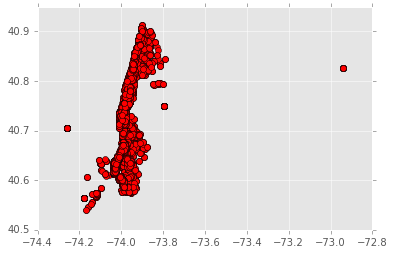

In [40]:
plt.plot(mainDF.Longtitude_Address, mainDF.Latitude_Address, 'ro')

### 4) Непосредственно исследование. А именно, проверка гепотез, визуализация результатов и т.д.

В этой фазе к данным применяются разнообразные методики моделирования, строятся модели и их параметры настраиваются на оптимальные значения. Обычно для решения любой задачи анализа данных существует несколько различных подходов. Некоторые подходы накладывают особые требования на представление данных. Таким образом часто бывает нужен возврат на шаг назад к фазе подготовки данных.
- Выбрать методику моделирования
- Сделать тесты для модели
- Построить модель
- Оценить модель

- Распределение по районам

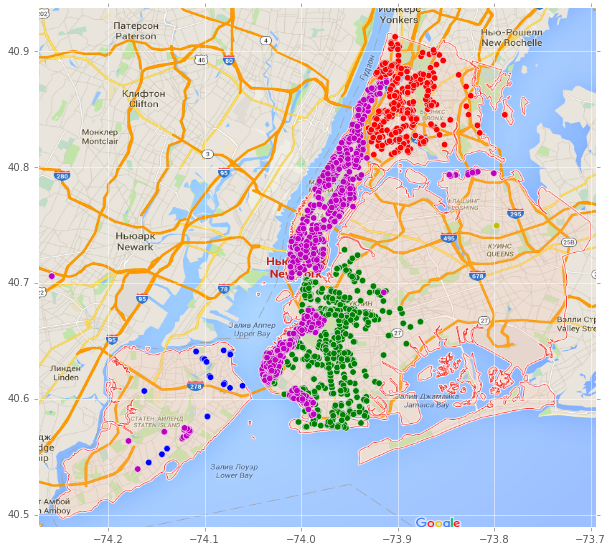

In [69]:
drawOnNYMap(mainDF.Longtitude_Address,
            mainDF.Latitude_Address,
            map(lambda label: colors[label], mainDF.District), size=10)

- Средняя стоимость за квадратный фут

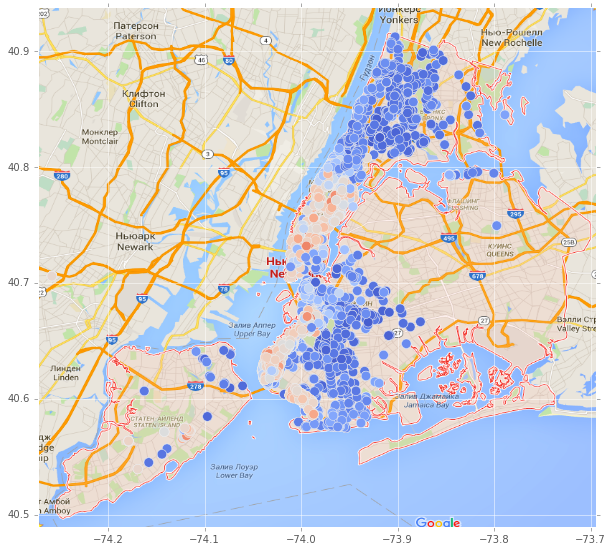

In [70]:
drawOnNYMap(mainDF.Longtitude_Address,
            mainDF.Latitude_Address,
            getColors(mainDF.Market_Value_per_SqFt.values), size=10, s=90)

### 5) Подведение итогов исследования.

На этом этапе проекта уже построена модель и получены количественные оценки её качества. Перед тем, как внедрять эту модель, необходимо убедиться, что мы достигли всех поставленных бизнес-целей. Основной целью этапа является поиск важных бизнес-задач, которым не было уделено должного внимания.
- Оценить результаты
- Сделать ревью процесса